<a href="https://colab.research.google.com/github/Oytuncevre/Travel-Tide-Project/blob/main/Travel_Tide_Mastery_Project_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🏨✈️**Travel Tide Rewards Program: Data-Driven Customer Segmentation and Personalization**


---



## **Project Background**

TravelTide, an innovative e-booking startup, is making its mark in the online travel industry with a clear mission: to create a personalized rewards program that keeps customers coming back to their platform. To achieve this, the company is conducting a comprehensive Customer Segmentation analysis aimed at boosting customer engagement. The marketing team has developed five enticing perks designed to elevate the customer experience: free hotel meals, free checked bags, no cancellation fees, exclusive discounts, and a one-night free hotel stay with a flight. The primary objective of this analysis is to identify distinct customer segments, each with unique preferences for these perks based on their past behaviors. This segmentation is a critical first step in tailoring the rewards program to meet the needs of diverse travelers. However, the ultimate measure of the program’s success will come from observing and analyzing customer reactions once these perks are rolled out, allowing TravelTide to refine and optimize the rewards to ensure they truly resonate with their audience.

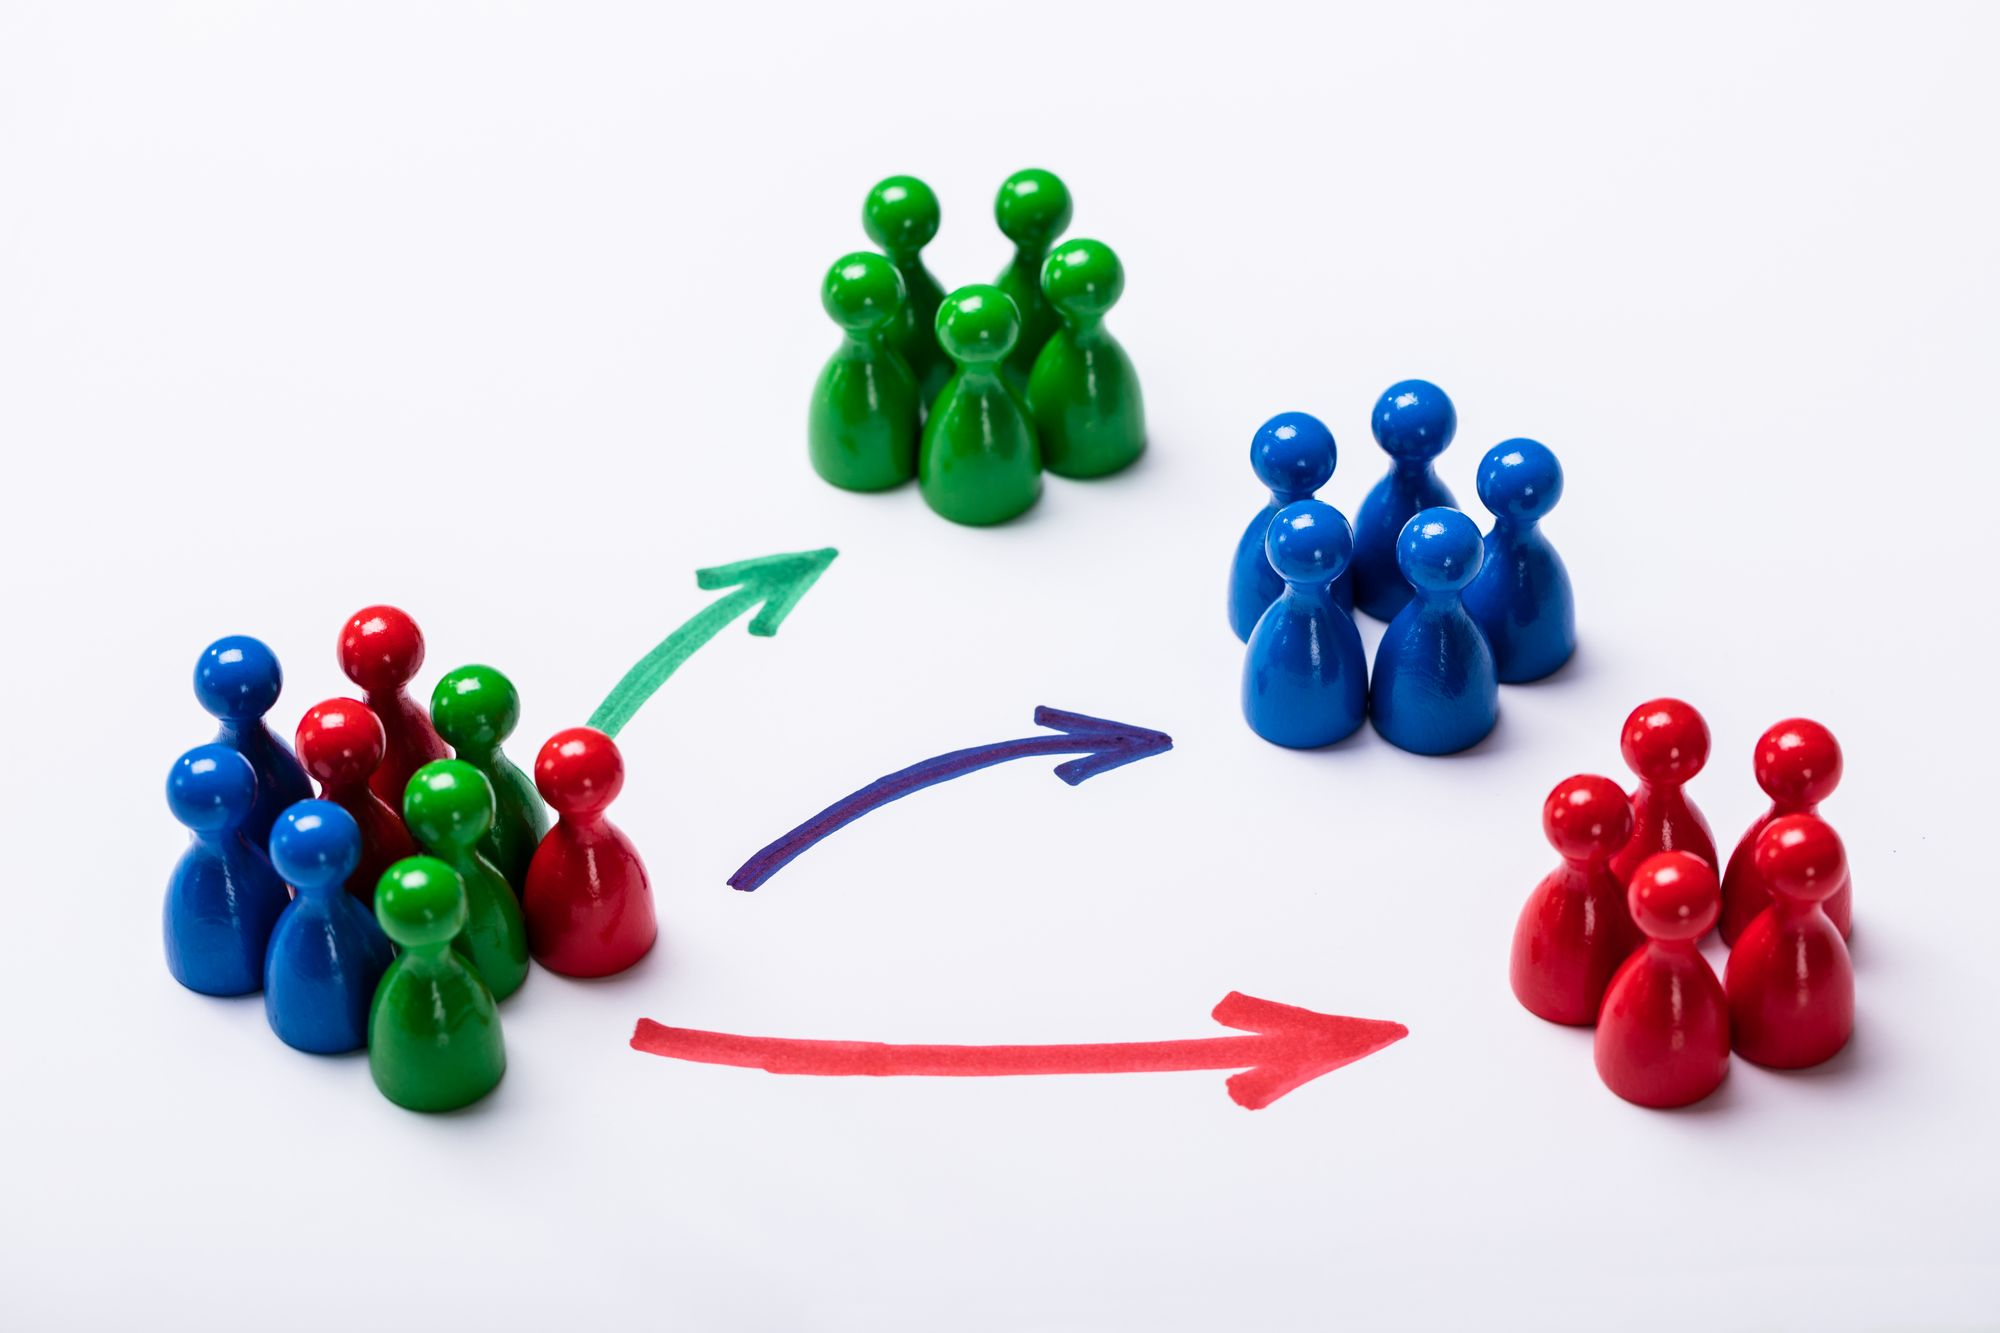

This report outlines the steps taken to achieve customer segmentation, the SQL code used to extract and analyze the data, using Tableau visualize the distribution of customer groups and perks assignment, and recommendations for further analysis to optimize the rewards program.



---



## **🔍 Methodology**
Our first step is to carefully identify the appropriate customer group for analysis. To ensure accurate and relevant segmentation, we concentrate on users who have shown significant engagement with the platform. Following the Marketing Team’s recommendations, we’ve defined the target cohort as users who started interacting with the platform after January 4, 2023, and have completed more than seven browsing sessions since then. This approach helps us build a robust dataset of meaningful user behavior while filtering out newer users with limited activity, ensuring a more reliable and insightful analysis.



---



##**Processes 1 by 1**

#### ***EDA***

*   **Data Collection:** Extracting customer data, including behavioral and demographic metrics, using an SQL query.

#### ***Feature Engineering - Devising Metrics***

*   **Data Exploration:** Developing key metrics such as the number of sessions, total trips, average checked bags, total hotel spending, and more.

#### ***Customer Segmentation - Grouping the Customers***

* **Customer Group Assignment:** Grouping customers into segments based on aggregated metrics.

* **Perk Definition:** Identifying the most relevant perks for each customer segment, considering demographic data and user activities related to hotels, flights, and sessions.

#### ***Analysis and Visualization in Tableau***

*  **Demographic Analysis:** Using Tableau to analyze customer segments by attributes such as age, gender, marital status, and parental status.


*   **Visualization:** Creating visual representations to showcase segment distributions, perk effectiveness, and behavioral patterns. These insights help refine marketing strategies and perk allocations.

#### ***Conclusions and Recommendations***

* Summarizing the project’s objectives and key findings while offering actionable recommendations based on customer segmentation and insights gained.

## **Data Exploration**

1. **Cohort Identification (cohort CTE):**

* This step filters and identifies users who have participated in more than seven sessions since January 4, 2023, forming a focused subset for detailed analysis.

2. **Metric Aggregation (custom_data CTE):**

* This section computes key metrics for each user, such as session frequency, average session duration, trip counts, conversion rates, and booking-related insights.

3.  **Customer Segmentation (customer_groups CTE):**

* Users are segmented into categories like Family, Groups, Business, and Frequent Travelers based on their behavior and aggregated metrics, enabling a deeper understanding of their travel patterns and preferences.

4.   **Perk Allocation (grouped_perks CTE):**

* Tailored perks are assigned to users based on their customer group, incentivizing loyalty and enhancing customer satisfaction.

5.   **Comprehensive Overview:**

* The final output combines demographic details with aggregated metrics, customer segments, and assigned perks, offering a holistic view of each user’s profile.

##**SQL Code**

This is the final Sql code for analysis.

In [ ]:
WITH session_based AS (
    SELECT
        s.session_id,
        s.user_id,
        s.trip_id,
        s.session_start,
        s.session_end,
        s.page_clicks,
        s.flight_discount,
        s.flight_discount_amount,
        s.hotel_discount,
        s.hotel_discount_amount,
        s.flight_booked,
        s.hotel_booked,
        s.cancellation,
        EXTRACT(EPOCH FROM (s.session_end - s.session_start)) AS session_duration,
        f.origin_airport,
        f.destination,
        f.destination_airport,
        f.seats,
        f.return_flight_booked,
        f.departure_time,
        f.return_time,
        f.checked_bags,
        f.trip_airline,
        f.destination_airport_lat,
        f.destination_airport_lon,
        f.base_fare_usd,
        h.hotel_name,
        CASE WHEN h.nights < 0 THEN 1 ELSE h.nights END AS nights,
        h.rooms,
        h.check_in_time,
        h.check_out_time,
        h.hotel_per_room_usd AS hotel_price_per_room_night_usd,
        u.home_airport_lat,
        u.home_airport_lon
    FROM sessions s
    LEFT JOIN users u ON s.user_id = u.user_id
    LEFT JOIN flights f ON s.trip_id = f.trip_id
    LEFT JOIN hotels h ON s.trip_id = h.trip_id
    WHERE s.user_id IN (
        SELECT user_id
        FROM sessions
        WHERE session_start > '2023-01-04'
        GROUP BY user_id
        HAVING COUNT(*) > 7
    )
),
session_user_based AS (
    SELECT
        user_id,
        SUM(page_clicks) AS num_clicks,
        COUNT(DISTINCT session_id) AS num_sessions,
        AVG(session_duration) AS avg_session_duration
    FROM session_based
    GROUP BY user_id
),
trip_based AS (
    SELECT
        user_id,
        COUNT(trip_id) AS total_trips,
        SUM(CASE
            WHEN flight_booked AND return_flight_booked THEN 2
            WHEN flight_booked THEN 1
            ELSE 0
        END) AS total_flights,
        SUM((hotel_price_per_room_night_usd * nights * rooms) * (1 - COALESCE(hotel_discount_amount, 0))) AS total_hotel_spend,
        AVG(EXTRACT(DAY FROM departure_time - session_end)) AS avg_time_before_trip,
        AVG(haversine_distance(home_airport_lat, home_airport_lon, destination_airport_lat, destination_airport_lon)) AS avg_km_flown,
        AVG(nights) AS avg_stay_duration_day,
        AVG(checked_bags) AS avg_checked_bags,
        AVG(seats) AS avg_flight_seats
    FROM session_based
    GROUP BY user_id
),
percentiles AS (
    SELECT
        PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY total_trips) AS p75_total_trips,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY total_hotel_spend) AS p50_total_hotel_spend
    FROM trip_based
),
main_q AS (
    SELECT
        sub.*,
        EXTRACT(YEAR FROM age(now(), u.birthdate)) AS age,
        CASE
            WHEN EXTRACT(YEAR FROM age(now(), u.birthdate)) BETWEEN 16 AND 25 THEN '16-25'
            WHEN EXTRACT(YEAR FROM age(now(), u.birthdate)) BETWEEN 26 AND 35 THEN '26-35'
            WHEN EXTRACT(YEAR FROM age(now(), u.birthdate)) BETWEEN 36 AND 45 THEN '36-45'
            WHEN EXTRACT(YEAR FROM age(now(), u.birthdate)) BETWEEN 46 AND 55 THEN '46-55'
            WHEN EXTRACT(YEAR FROM age(now(), u.birthdate)) BETWEEN 56 AND 65 THEN '56-65'
            ELSE '65+'
        END AS age_group,
        u.gender,
        u.married,
        u.has_children,
        u.home_country,
        u.home_city,
        EXTRACT(YEAR FROM age(now(), u.sign_up_date)) AS time_spent,
        t.total_trips,
        t.total_flights,
        t.total_hotel_spend,
        t.avg_km_flown,
        t.avg_stay_duration_day,
        t.avg_checked_bags,
        t.avg_flight_seats,
        CASE
            WHEN u.married IS TRUE THEN 'Married'
            ELSE 'Non-Married'
        END AS marital_status,
        CASE
            WHEN u.gender = 'F' THEN 'Female'
            ELSE 'Male'
        END AS gender_status,
        CASE
            WHEN u.has_children IS FALSE THEN 'No'
            ELSE 'Yes'
        END AS has_children_status
    FROM users u
    LEFT JOIN session_user_based AS sub ON sub.user_id = u.user_id
    JOIN trip_based t ON sub.user_id = t.user_id
),
customer_groups AS (
    SELECT
        *,
        CASE
            WHEN total_trips > (SELECT p75_total_trips FROM percentiles) THEN 'Frequent Traveler'
            WHEN avg_flight_seats > 1 THEN 'Groups'
            WHEN has_children IS TRUE THEN 'Family'
            WHEN has_children IS FALSE AND married IS TRUE THEN 'Couple'
            WHEN avg_stay_duration_day < 3 AND avg_checked_bags <= 1 THEN 'Business'
            WHEN total_hotel_spend >= (SELECT p50_total_hotel_spend FROM percentiles) THEN 'Solo'
            ELSE 'Other'
        END AS customer_group
    FROM main_q
)
SELECT
    *,
    CASE
        WHEN customer_group = 'Family' THEN 'Exclusive Discounts'
        WHEN customer_group = 'Groups' THEN 'No Cancellation Fees'
        WHEN customer_group = 'Business' THEN '1 Night Free Hotel with Flight'
        WHEN customer_group = 'Solo' THEN 'Free Hotel Meal'
        WHEN customer_group = 'Couple' THEN 'Free Checked Bag'
        WHEN customer_group = 'Frequent Traveler' THEN 'Priority Boarding'
        ELSE '10% Discount for First Booking'
    END AS preferred_perk
FROM customer_groups;


##**Customer groups and Perks Assignments**

#### **Frequent Travelers**

**Characteristics:**

Frequent Travelers are those who take more trips than 75% of users, based on the 75th percentile threshold. These individuals demonstrate high engagement with travel services and prioritize frequent travel.

**Perk:**

Priority Boarding — This perk ensures convenience and efficiency, enhancing their travel experience and encouraging continued loyalty.

#### **Couple Travelers**

**Characteristics:**

Couples are typically married, without children, and exhibit travel patterns that include two flight seats, one hotel room, and slightly more than one checked bag.


**Perk:**

Free Checked Bag — This benefit provides added convenience, making travel more enjoyable for couples.

#### **Group Travelers**

**Characteristics:**

 Group Travelers usually travel with multiple companions, as indicated by higher averages for flight seats, checked bags, and hotel rooms. They are often unmarried, suggesting travel with friends or colleagues.

**Perk:**

No Cancellation Fees — This perk adds flexibility, catering to the complex plans of group travelers.

#### **Family Travelers**

**Characteristics:**

Families are identified by travel patterns that include multiple flight seats, more checked bags, and one hotel room. They also have children, influencing their travel needs.

**Perk:**

Exclusive Discounts — Offering cost-saving opportunities appeals to value-seeking families, fostering loyalty and repeat bookings.


#### **Business Travelers**

**Characteristics:**

Business Travelers tend to have shorter hotel stays, fewer checked bags, and higher spending on accommodations. They prioritize efficiency and premium services.

**Perk:**

1 Night Free Hotel with Flight — This benefit incentivizes bookings by adding value for frequent, short business trips.

#### **Solo Travelers**

**Characteristics:**

Solo Travelers typically have moderate hotel spending and fewer trips, focusing on individual experiences rather than group or family travel.

**Perk:**

Free Hotel Meal — This thoughtful perk enhances their stay and adds a touch of comfort to solo journeys.

#### **Other Travelers**

**Characteristics:**

This group includes users who do not fall into the above categories, reflecting diverse or unpredictable travel patterns.

**Perk:**

10% Discount for First Booking — A first-time booking discount serves as a compelling incentive to engage these travelers and build loyalty.


These tailored perks are designed to align with the unique preferences and travel behaviors of each segment, improving the overall customer experience. By offering personalized benefits, TravelTide aims to drive higher user satisfaction, increase engagement, and foster long-term customer loyalty.


---



## **Distribution Analysis**

The following analysis explores the distribution of customer groups and their preferred perks, highlighting how specific benefits align with the unique needs of each segment:

* **Groups: No Cancellation Fees**

  	•	Proportion: 22.69%

	  •	Reasoning: Group travelers often face challenges in coordinating plans, increasing the likelihood of itinerary changes. The “No Cancellation Fees” perk provides flexibility, reducing financial risks and enhancing their booking confidence.

* **Families: Exclusive Discounts**

 	  •	Proportion: 21.17%

	  •	Reasoning: Traveling with multiple family members can be costly. Families value “Exclusive Discounts” as they make vacations more affordable, fostering loyalty by addressing their financial concerns.

* **Frequent Travelers: Priority Boarding**

  	•	Proportion: 14.75%

	  •	Reasoning: Frequent travelers prioritize convenience and efficiency. The “Priority Boarding” perk allows them to board early, minimizing delays and improving their overall travel experience.

* **Couples: Free Checked Bags**

 	  •	Proportion: 15.74%

	  •	Reasoning: Couples often require additional luggage space for their trips. The “Free Checked Bags” perk saves money and adds convenience, especially for longer journeys.

* **Business Travelers: 1 Night Free Hotel with Flight**

 	  •	Proportion: 9.24%

	  •	Reasoning: Business travelers appreciate bundled offers like “1 Night Free Hotel with Flight.” This perk simplifies their booking process and reduces costs for short business trips, aligning with their need for efficiency.

* **Solo Travelers: Free Hotel Meal**

 	  •	Proportion: 7.99%

	  •	Reasoning: Budget-conscious solo travelers benefit from perks like “Free Hotel Meal,” which helps save on dining expenses while adding convenience during their stay.

* **Other: 10% Discount for First Booking**

 	  •	Proportion: 8.42%

	  •	Reasoning: New or infrequent travelers are drawn to the “10% Discount for First Booking.” This incentive encourages them to try TravelTide, creating opportunities for building loyalty.

By analyzing these distributions, we can identify clear connections between customer segments and their preferred perks. This insight allows TravelTide to design targeted strategies that meet customer needs, improve satisfaction, and enhance engagement.

## **Demographic Analysis of Perks by Age Group**

**Age Group Analysis:**

•	16-25: Younger travelers are highly drawn to the “10% Discount for First Booking,” highlighting their price sensitivity and tendency to seek savings, particularly as many are newer users.

•	26-35: This group favors bundled perks like “Free Hotel Meals” and “1 Night Free Hotel with Flight,” reflecting their interest in value-added travel packages.

•	36-45 and 46-55: These age groups show a strong preference for perks such as “Priority Boarding,” “No Cancellation Fees,” and “Exclusive Discounts,” indicating a demand for convenience and flexibility.

•	55-65 and 65+: Older travelers demonstrate a lower overall interest in perks but still value options like “Exclusive Discounts” and “No Cancellation Fees,” which emphasize reliability and practicality.





**Recommendations**

* Personalized Marketing:
Leverage the insights from customer groups and their preferred perks to design targeted marketing campaigns. For example, offer “Frequent Travelers” promotions related to “priority boarding” and cater to “Solo” travelers with deals for hotel meals.

* Flexible Perk Adjustments:
Regularly assess the effectiveness of each perk and adjust based on customer engagement and feedback. For instance, if “free checked bags” prove popular with “Couple” travelers, consider extending this offer to other suitable groups.

* Tiered Rewards Structure:
Introduce a tiered reward system where frequent travelers can unlock higher-level benefits, such as flight upgrades or VIP lounge access, based on their travel activity.

* Refined Customer Segmentation:
Conduct deeper analysis on subgroups within each customer category. For instance, evaluate if “Frequent Travelers” who are also “Business” customers have different preferences compared to those traveling for leisure.

* Loyalty Points Program:
Implement a points-based system that allows customers to accumulate points with each booking. These points can be redeemed for flight discounts, free hotel stays, or travel accessories.

**Additional Steps for Effective Implementation**

* Data-Driven Personalization:
Constantly monitor customer behavior to adjust perks and ensure the rewards program remains relevant and effective as travel patterns evolve.

* A/B Testing for Perks:
Conduct A/B testing on different perks within customer segments to identify the most effective offerings. For example, test whether “1 night free hotel with flight” results in greater engagement among “Business” travelers compared to other rewards.

* Customer Feedback Loop:
Gather customer feedback on the rewards program to refine offerings based on what customers value most.

* Targeted Marketing Campaigns:
Promote the rewards program through targeted campaigns, emphasizing perks that resonate most with specific segments, such as flexibility for groups or discounts for families.

* Seamless Integration into App Experience:
Ensure the rewards program is integrated smoothly into the platform’s booking process, making it easy for customers to view, redeem, and track their rewards.

* This strategy offers a comprehensive framework for leveraging data to improve customer satisfaction and loyalty, ultimately increasing engagement and revenue for the business.


---

